In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations
from itertools import chain
from collections import namedtuple
import pickle
import os.path

import sys
import numpy as np
import math
import random

from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Bidirectional, Input, concatenate, add
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, AveragePooling1D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.advanced_activations import PReLU
from sklearn.metrics import average_precision_score, roc_auc_score


Using TensorFlow backend.


In [2]:
def oneHotEncodingForSeq(rawSeqList):
    if len(rawSeqList) != 0:
        encodedSeq = np.zeros((len(rawSeqList), len(rawSeqList[0]), 5))
        for i in range(len(rawSeqList)):
            sequence = rawSeqList[i]
            j = 0
            for s in sequence:
                if s == 'A' or s == 'a':
                    encodedSeq[i][j] = [1,0,0,0,0]
                elif s == 'T' or s == 't':
                    encodedSeq[i][j] = [0,1,0,0,0]
                elif s == 'C' or s == 'c':
                    encodedSeq[i][j] = [0,0,1,0,0]
                elif s == 'G' or s == 'g':
                    encodedSeq[i][j] = [0,0,0,1,0]
                elif s == 'N' or s == 'n':
                    encodedSeq[i][j] = [0,0,0,0,1]
                j = j + 1
        return encodedSeq
    else:
        return 0

def oneHotEncodingForSS(rawStructureList):
    if len(rawStructureList) != 0:
        encodedStructure = np.zeros((len(rawStructureList), len(rawStructureList[0]), 7))
        for i in range(len(rawStructureList)):
            structure = rawStructureList[i]
            j = 0
            for s in structure:
                if s == 'U':
                    encodedStructure[i][j] = [1,0,0,0,0,0,0]
                elif s == 'E':
                    encodedStructure[i][j] = [0,1,0,0,0,0,0]
                elif s == 'L':
                    encodedStructure[i][j] = [0,0,1,0,0,0,0]
                elif s == 'R':
                    encodedStructure[i][j] = [0,0,0,1,0,0,0]
                elif s == 'H':
                    encodedStructure[i][j] = [0,0,0,0,1,0,0]
                elif s == 'M':
                    encodedStructure[i][j] = [0,0,0,0,0,1,0]
                elif s == 'I':
                    encodedStructure[i][j] = [0,0,0,0,0,0,1]
                j = j + 1
        return encodedStructure
    else:
        return 0

def matchingLabelBetweenSeqAndStructure(seqLabelList, structureLabelList, kindOfData):
    print>>sys.stderr, 'Checking label similarity between sequence and structure of ' + kindOfData + ' data'
    for index in range(len(seqLabelList)):
        if seqLabelList[index] != structureLabelList[index]:
            print>>sys.stderr, 'ERROR: label mismatch between sequence and structure'

def sequenceModel(seqInput):
    seqCov = Conv1D(filters=512,
        kernel_size=8,
        padding = "valid",
        input_shape =(200, 5),
        activation="relu",
        strides=1)(seqInput) 

    seqPool = MaxPooling1D(pool_size = 3, strides = 3)(seqCov)
    seqDout1 = Dropout(rate = 0.7)(seqPool)
    seqBiLstm = Bidirectional(LSTM(units = 128, return_sequences = True))(seqDout1)
    seqDout2 = Dropout(rate = 0.7)(seqBiLstm)
    seqFlat = Flatten()(seqDout2)
    seqDen2 = Dense(256, kernel_initializer='glorot_uniform', activation = 'relu')(seqFlat)
    seqDout4 = Dropout(rate = 0.7)(seqDen2)

    return seqDout4

def structureSubModel(ssInput):
    ssConv = Conv1D(filters=256,
                    kernel_size=12,
            padding = "valid",
            activation="relu",
            strides=1)(ssInput)
    ssPool = AveragePooling1D(pool_size = 5, strides = 5)(ssConv)
    ssDout1 = Dropout(rate=0.7)(ssPool)
    seqBiLstm = Bidirectional(LSTM(units = 128, return_sequences = True))(ssDout1)
    seqDout2 = Dropout(rate = 0.7)(seqBiLstm)
    ssFlat = Flatten()(seqDout2)
    ssDen1 = Dense(256, kernel_initializer='glorot_uniform', activation = 'relu')(ssFlat)
    ssDout2 = Dropout(rate=0.7)(ssDen1)

    return ssDout2


In [3]:

def get_predict_func() :
    
    structureSeqLength = 200
    
    # Building deep learning model
    training_net = []
    # deep learning sub-model for sequence
    seqInput = Input(shape = (200, 5))
    seqModel = sequenceModel(seqInput)
    training_net.append(seqModel)

    # deep learning sub-model for structure
    ss_training_net = []
    ssInput1 = Input(shape = (structureSeqLength, 7))
    ssInput2 = Input(shape = (structureSeqLength, 7))
    ssInput3 = Input(shape = (structureSeqLength, 7))

    ss_training_net.append(structureSubModel(ssInput1))
    ss_training_net.append(structureSubModel(ssInput2))
    ss_training_net.append(structureSubModel(ssInput3))

    ss_merged_model = add(ss_training_net)
    ss_den1 = Dense(256, kernel_initializer = 'glorot_uniform', activation = 'relu')(ss_merged_model)
    ss_dout1 = Dropout(rate = 0.7)(ss_den1)
    training_net.append(ss_dout1)
    merged_model = concatenate(training_net)

    den1 = Dense(256, kernel_initializer = 'glorot_uniform', activation = 'relu')(merged_model)
    dout1 = Dropout(rate = 0.7)(den1)

    den2 = Dense(128, kernel_initializer = 'glorot_uniform', activation = 'relu')(dout1)
    dout2 = Dropout(rate = 0.7)(den2)
    den3 = Dense(64, activation = 'relu')(dout2)
    den4 = Dense(1, activation = 'sigmoid')(den3)
    model = Model(inputs = [seqInput, ssInput1, ssInput2, ssInput3], outputs = den4)

    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    model.load_weights('DeepPASTA_polyA_site_learned.hdf5')
    
    def _predict(testingSequenceList, testingStructureList1, testingStructureList2, testingStructureList3) :
        
        encodedTestingSeq = oneHotEncodingForSeq(testingSequenceList)
        encodedTestingStructure1 = oneHotEncodingForSS(testingStructureList1)
        encodedTestingStructure2 = oneHotEncodingForSS(testingStructureList2)
        encodedTestingStructure3 = oneHotEncodingForSS(testingStructureList3)

        testingData = []
        testingData.append(encodedTestingSeq)
        testingData.append(encodedTestingStructure1)
        testingData.append(encodedTestingStructure2)
        testingData.append(encodedTestingStructure3)

        preds = model.predict(testingData, batch_size = 2042, verbose = 0)

        return preds
    
    return _predict

predict_func = get_predict_func()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#Load dataframe of sequences to predict APA for

df = pd.read_csv('../PolyApredictors/apa_leslie_derti_apadb_pair_data_df_pair.csv', sep='\t')


In [5]:
#Pad sequences to fit DeepPASTA input format

df['seq_p'] = df['wide_seq_ext_prox'].str.slice(175-70, 175-70+205-5)
df['seq_d'] = df['wide_seq_ext_dist'].str.slice(175-70, 175-70+205-5)


In [6]:
#Generate RNA structures

with open("test1_site_pred_p.fa", "wt") as temp_f :
    i = 0
    for _, row in df.iterrows() :
        temp_f.write(">seq" + str(i) + "\n" + row['seq_p'] + "\n")
        i += 1

!./generating_secondary_structure_from_sequence/RNAshapes -f ./test1_site_pred_p.fa -s -c 5 -t 1 -w 100 -W 100 -O 'D{%s\n}' > temp_shapes1_site_pred.txt
!python2 ./generating_secondary_structure_from_sequence/combining_substructure.py -i temp_shapes1_site_pred.txt -o temp_shapes2_site_pred.txt
!python2 ./generating_secondary_structure_from_sequence/filtering_number_of_ss.py -n 3 -i temp_shapes2_site_pred.txt -o temp_shapes3_site_pred.txt
!python2 ./generating_secondary_structure_from_sequence/shape_assign_per_nucleotide.py -c 3 -i temp_shapes3_site_pred.txt -o temp_shapes4_site_pred_p.txt

structs_prox_1_p = []
structs_prox_2_p = []
structs_prox_3_p = []
with open("temp_shapes4_site_pred_p.txt", "rt") as temp_f :
    i = 0
    for line in temp_f.readlines() :
        if i % 4 == 1 :
            struct_prox = line.strip()
            structs_prox_1_p.append(struct_prox)
        if i % 4 == 2 :
            struct_prox = line.strip()
            structs_prox_2_p.append(struct_prox)
        if i % 4 == 3 :
            struct_prox = line.strip()
            structs_prox_3_p.append(struct_prox)
        i += 1


Starting program ...
Output from RNAshapes: temp_shapes1_site_pred.txt
Output filename: temp_shapes2_site_pred.txt
Starting program ...
Number of suboptimal structures considered: 3
Output from RNAshapes: temp_shapes2_site_pred.txt
Output filename: temp_shapes3_site_pred.txt
Starting program ...
Number of structure: 3
Output from RNAshapes to assign structure: temp_shapes3_site_pred.txt
Output file name: temp_shapes4_site_pred_p.txt


In [7]:
#Generate RNA structures

with open("test1_site_pred_d.fa", "wt") as temp_f :
    i = 0
    for _, row in df.iterrows() :
        temp_f.write(">seq" + str(i) + "\n" + row['seq_d'] + "\n")
        i += 1

!./generating_secondary_structure_from_sequence/RNAshapes -f ./test1_site_pred_d.fa -s -c 5 -t 1 -w 100 -W 100 -O 'D{%s\n}' > temp_shapes1_site_pred.txt
!python2 ./generating_secondary_structure_from_sequence/combining_substructure.py -i temp_shapes1_site_pred.txt -o temp_shapes2_site_pred.txt
!python2 ./generating_secondary_structure_from_sequence/filtering_number_of_ss.py -n 3 -i temp_shapes2_site_pred.txt -o temp_shapes3_site_pred.txt
!python2 ./generating_secondary_structure_from_sequence/shape_assign_per_nucleotide.py -c 3 -i temp_shapes3_site_pred.txt -o temp_shapes4_site_pred_d.txt

structs_dist_1_d = []
structs_dist_2_d = []
structs_dist_3_d = []
with open("temp_shapes4_site_pred_d.txt", "rt") as temp_f :
    i = 0
    for line in temp_f.readlines() :
        if i % 4 == 1 :
            struct_dist = line.strip()
            structs_dist_1_d.append(struct_dist)
        if i % 4 == 2 :
            struct_dist = line.strip()
            structs_dist_2_d.append(struct_dist)
        if i % 4 == 3 :
            struct_dist = line.strip()
            structs_dist_3_d.append(struct_dist)
        i += 1


Starting program ...
Output from RNAshapes: temp_shapes1_site_pred.txt
Output filename: temp_shapes2_site_pred.txt
Starting program ...
Number of suboptimal structures considered: 3
Output from RNAshapes: temp_shapes2_site_pred.txt
Output filename: temp_shapes3_site_pred.txt
Starting program ...
Number of structure: 3
Output from RNAshapes to assign structure: temp_shapes3_site_pred.txt
Output file name: temp_shapes4_site_pred_d.txt


In [10]:
#Execute all pA site prediction model

testingSequenceList_p = [row['seq_p'] for _, row in df.iterrows()]
testingStructList1_p = structs_prox_1_p
testingStructList2_p = structs_prox_2_p
testingStructList3_p = structs_prox_3_p

y_pred_p = predict_func(testingSequenceList_p, testingStructList1_p, testingStructList2_p, testingStructList3_p)[:, 0][:, None]
y_pred_p = np.clip(y_pred_p, 1e-6, 1. - 1e-6)
score_prox = np.log(y_pred_p / (1. - y_pred_p))

testingSequenceList_d = [row['seq_d'] for _, row in df.iterrows()]
testingStructList1_d = structs_dist_1_d
testingStructList2_d = structs_dist_2_d
testingStructList3_d = structs_dist_3_d

y_pred_d = predict_func(testingSequenceList_d, testingStructList1_d, testingStructList2_d, testingStructList3_d)[:, 0][:, None]
y_pred_d = np.clip(y_pred_d, 1e-6, 1. - 1e-6)
score_dist = np.log(y_pred_d / (1. - y_pred_d))


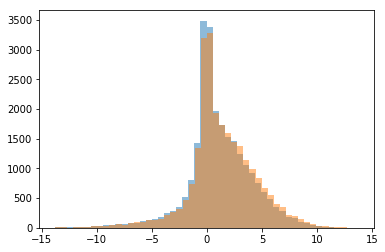

In [14]:
import matplotlib.pyplot as plt

f = plt.figure()

plt.hist(score_prox[:, 0], bins=50, alpha=0.5)
plt.hist(score_dist[:, 0], bins=50, alpha=0.5)

plt.show()


In [12]:

df['score_prox'] = score_prox[:, 0]
df['score_dist'] = score_dist[:, 0]


In [13]:
#Re-save prediction df

df[['gene_id', 'seq_prox', 'seq_dist', 'score_prox', 'score_dist']].to_csv("apa_leslie_derti_apadb_pair_data_df_pair_deeppasta_site_predictor.csv", sep='\t', index=False)
